#                                Browser fingerprint analysis 

## Importing of necessary librairies

In [1]:
%matplotlib notebook
import MySQLdb as mdb
import numpy as np
import csv
import sys
import re
sys.path.append("../src/")
from src.fingerprint import Fingerprint
from src import CSV_DELIMITER

import pandas as pd
import matplotlib.pyplot as plt
from src.analyse import compute_normalized_entropy

DATA_PATH_REL = "../../data/"

#Matplotlib figures inserted into the notebook
%pylab inline

import datetime as datetime
#import seaborn
import sklearn
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
#import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


## Read the file

In [2]:
# Exclusion of some attributes
ATTRIBUTES_TO_EXCLUDE = [Fingerprint.COUNTER, Fingerprint.CREATION_TIME, Fingerprint.END_TIME, Fingerprint.CONSISTENT]

In [3]:
# read the file
df = pd.read_csv(DATA_PATH_REL + "processed/fingerprint_dataset.csv", delimiter=CSV_DELIMITER, engine="python")
df["creationDate"] = pd.to_datetime(df["creationDate"])

## Visualization of consistent fingerprints

In [4]:
# Analysis of consistent fingerprints
attributes_to_analyze = [attribute for attribute in df.columns.tolist() if attribute not in ATTRIBUTES_TO_EXCLUDE]
df_consistent = df[df[Fingerprint.CONSISTENT] == True ]
print("There are {:d} elements in df_consistent".format(len(df_consistent)))

There are 48714 elements in df_consistent


In [6]:
# Name of attributes
print(df_consistent.columns, "There are {:d} columns in df_consistent".format(len(df_consistent.columns)))

Index(['counter', 'id', 'creationDate', 'endDate', 'addressHttp',
       'userAgentHttp', 'acceptHttp', 'connectionHttp', 'encodingHttp',
       'languageHttp', 'orderHttp', 'pluginsJSHashed', 'platformJS',
       'cookiesJS', 'dntJS', 'timezoneJS', 'resolutionJS', 'localJS',
       'sessionJS', 'canvasJSHashed', 'fontsFlashHashed', 'resolutionFlash',
       'languageFlash', 'platformFlash', 'browserFamily',
       'globalBrowserVersion', 'minorBrowserVersion', 'majorBrowserVersion',
       'os', 'rendererWebGLJS', 'vendorWebGLJS', 'pluginsJS', 'consistent'],
      dtype='object') There are 33 columns in df_consistent


In [149]:
# Visualization of the first 5 lines
df_consistent.head(5)

,counter,id,creationDate,endDate,addressHttp,userAgentHttp,acceptHttp,connectionHttp,encodingHttp,languageHttp,...,platformFlash,browserFamily,globalBrowserVersion,minorBrowserVersion,majorBrowserVersion,os,rendererWebGLJS,vendorWebGLJS,pluginsJS,consistent
15,17,0f4f77e3-80da-4b4a-b9c0-f5e8c4239380,2015-07-27 11:00:00,None,24f5398bba446ce8dadfd3d23ca2f4e58895e76e,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","en-US,en;q=0.8,fr;q=0.6",...,Linux,Chrome,440,0,44,Linux,Mesa DRI Intel(R) Haswell Mobile,Intel Open Source Technology Center,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True
17,19,74bf8f6f-0114-44b4-9bca-1cfc52ffc2d3,2015-07-27 12:00:00,None,24f5398bba446ce8dadfd3d23ca2f4e58895e76e,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","en-US,en;q=0.8,fr;q=0.6",...,Linux,Chrome,440,0,44,Linux,Mesa DRI Intel(R) Haswell Mobile,Intel Open Source Technology Center,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True
18,20,df46c5fb-9889-4ff4-9f51-e5af591f3460,2015-07-27 12:00:00,None,24f5398bba446ce8dadfd3d23ca2f4e58895e76e,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","en-US,en;q=0.8,fr;q=0.6",...,Linux,Chrome,440,0,44,Linux,Mesa DRI Intel(R) Haswell Mobile,Intel Open Source Technology Center,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True
19,21,dc031028-a4ea-4ce8-a362-17b07a4f4d65,2015-07-27 12:00:00,2015-07-28 11:00:00,90f2974eff1d1b3f05d01f413cf0241fae23352e,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_4...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","fr-FR,fr;q=0.8,en-US;q=0.6,en;q=0.4",...,Mac OS 10.10.4,Chrome,440,0,44,Mac OS X,Intel HD Graphics 5000 OpenGL Engine,Intel Inc.,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True
20,22,d51d09c6-2596-4958-bfe7-0352af2aaccf,2015-07-27 12:00:00,2015-07-29 06:00:00,2515ee56512877237d467911f5c55be53eea3550,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","fr-FR,fr;q=0.8,en-US;q=0.6,en;q=0.4",...,Linux,Chrome,430,0,43,Linux,Not supported,Not supported,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True


In [23]:
print("Statistics on dataset filtered: only consistent browsers") 
number_distinct_list=[]
for attribute in attributes_to_analyze:
    nb_distinct_values_by_attribute = df_consistent[attribute].value_counts()
    nb_distinct_values_global = nb_distinct_values_by_attribute.count()
    nb_unique_values = len(nb_distinct_values_by_attribute[nb_distinct_values_by_attribute.values == 1])


    number_distinct_list.append({
           "Attribute": attribute,
           "Distinct values": nb_distinct_values_global,
           "Unique values": nb_unique_values
      })   
number_distinct_df=pd.DataFrame(number_distinct_list).sort_values(by="Distinct values", ascending=False).reset_index(drop=True)
number_distinct_df

Statistics on dataset filtered: only consistent browsers


,Attribute,Distinct values,Unique values
0,addressHttp,15726,10834
1,fontsFlashHashed,4679,2149
2,id,4643,2123
3,pluginsJSHashed,4186,1940
4,pluginsJS,4185,1940
5,userAgentHttp,2286,980
6,canvasJSHashed,930,289
7,rendererWebGLJS,489,108
8,resolutionJS,446,218
9,languageHttp,422,89


## Descriptive analysis of consistent fingerprints

In [10]:
def display_entropy(df, attributes):
    data_df = []
    for attribute in attributes:
        data_df.append({
           "Attribute": attribute,
           "Relative entropy": compute_normalized_entropy(df, attribute)
       })    
    entropy_df = pd.DataFrame(data_df).sort_values(by="Relative entropy", ascending=False).reset_index(drop=True)
    print(entropy_df)

attributes = [attribute for attribute in attributes_to_analyze if attribute != "id"]
display_entropy(df_consistent, attributes_to_analyze)

               Attribute  Relative entropy
0            addressHttp          0.888301
1                     id          0.781561
2              pluginsJS          0.630395
3          userAgentHttp          0.613847
4        pluginsJSHashed          0.610079
5       fontsFlashHashed          0.542996
6         canvasJSHashed          0.487428
7           languageHttp          0.320505
8           resolutionJS          0.289189
9   globalBrowserVersion          0.269478
10       rendererWebGLJS          0.266548
11   majorBrowserVersion          0.264609
12       resolutionFlash          0.232677
13            timezoneJS          0.227500
14         platformFlash          0.222875
15             orderHttp          0.193803
16                    os          0.171668
17         languageFlash          0.164726
18          encodingHttp          0.122460
19         vendorWebGLJS          0.116709
20            platformJS          0.108445
21         browserFamily          0.087173
22         

In [143]:
# terms : effective, %
# number of unique terms
# most common terms
def terms_analysis(df, attribute):
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df_consistent['id'] == user_id]
        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                attribute : value
            })
    df_stats = pd.DataFrame(tmp_stats)
    
    nb = df_stats[attribute].value_counts()
    df_nb = pd.DataFrame(nb)
    
    nb_percent = nb/nb.sum()*100
    df_nb_percent = pd.DataFrame(nb_percent)
    
    tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
    tab.columns = ['effective', '%']
    
    
    print(tab)
    print()
    
    df_nb[:20].plot(kind='barh', stacked=False, width=0.9)
    plt.gca().invert_yaxis() 
    plt.grid(axis='x', linestyle = 'dashed')
    plt.title('The 20 first {}'.format(attribute))
    plt.xlabel('effective')
    plt.ylabel(attribute)
    plt.show()
    
    print("There are {:d} unique terms for the attribute '{}'".format(len(nb[nb.values == 1]), attribute))
    print()
    print("The most used terms are: \n{}".format(nb[:5]))

     effective          %
yes       4262  89.537815
no         498  10.462185



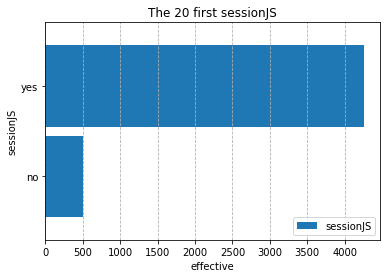

There are 0 unique terms for the attribute 'sessionJS'

The most used terms are: 
yes    4262
no      498
Name: sessionJS, dtype: int64


In [145]:
terms_analysis(df_consistent, 'sessionJS')

The distinct values for the attribute 'languageHttp' are : 
 ['de' 'pt' 'ru' 'en' 'fr' 'cs' 'da' 'it' 'nl' 'sv' 'sl' 'es' 'nb' 'hu'
 'pl' 'sh' 'ja' 'ac' 'uk' 'zh' 'tr' 'az' 'sk' 'fi' 'ko' 'th' 'vi' 'hr'
 'ro' 'an' 'ch' 'ca' 'ar' 'lt' 'el' 'af' 'bg' 'et']

    effective          %
en       2672  53.968895
ru        850  17.168249
fr        583  11.775399
de        320   6.463341
es         79   1.595637
it         61   1.232074
pl         59   1.191678
zh         57   1.151283
nl         52   1.050293
pt         42   0.848313
hu         35   0.706928
cs         21   0.424157
ja         18   0.363563
uk         13   0.262573
da         12   0.242375
tr          8   0.161584
ac          8   0.161584
sv          8   0.161584
fi          6   0.121188
vi          6   0.121188
ko          5   0.100990
sk          5   0.100990
af          4   0.080792
hr          4   0.080792
lt          3   0.060594
sl          3   0.060594
el          2   0.040396
nb          2   0.040396
sh          2   0.0

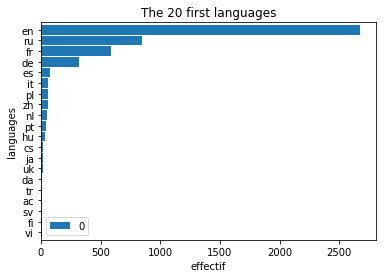

There are 7 unique terms for the attribute 'languageHttp'

The most used terms are: 
en    2672
ru     850
fr     583
de     320
es      79
Name: 0, dtype: int64


In [10]:
# terms analysis for the attribute 'languageHttp'
tmp_stats = []
ids = set(df_consistent['id'].unique())
for user_id in ids:
    df_user_id = df_consistent[df_consistent['id'] == user_id]
    different_values = df_user_id['languageHttp'].unique()
    for value in different_values:
        tmp_stats.append({
            "id": user_id,
            'languageHttp' : value
        })
df_stats = pd.DataFrame(tmp_stats)

language_http=df_stats['languageHttp']
language_http_less_nan=language_http.dropna()
language_http_less_nan_list= language_http_less_nan.values.tolist()

languages = []

# takes the first two characters
for i in range(0,len(language_http_less_nan_list)):    
    languages.append(language_http_less_nan_list[i][:2])

langues_df = pd.DataFrame(languages)

print("The distinct values for the attribute 'languageHttp' are : \n {}".format(langues_df[0].unique()))

    
nb = langues_df[0].value_counts()
df_nb = pd.DataFrame(nb)
    
nb_percent = nb/nb.sum()*100
df_nb_percent = pd.DataFrame(nb_percent)
    
tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
tab.columns = ['effective', '%']

print()
print(tab)
print()

df_nb[:20].plot(kind='barh', stacked=False, width=0.9)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle = 'dashed')
plt.title('The 20 first languages')
plt.xlabel('effective')
plt.ylabel('languages')
plt.show()

print("There are {:d} unique terms for the attribute 'languageHttp'".format(len(nb[nb.values == 1])))
print()
print("The most used terms are: \n{}".format(nb[:5]))


In [102]:
#modality of plugins
tmp_stats = []
plugins=re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(df_consistent['pluginsJS']))
plugins_df=pd.DataFrame(plugins)
plugins_df[0].unique()

array(['Chrome PDF Viewer', 'Chromium PDF Viewer',
       'Default Browser Helper', 'Shockwave Flash', 'DivX',
       'Gnome Shell Integration', 'Google Update', 'Native Client',
       'Adobe Acrobat'], dtype=object)

In [8]:
def analysis_terms_splited(df, attribute, split_function):
    tmp_dataset = []
    tmp_stats = []
    ids = set(df_consistent['id'].unique())
    for user_id in ids:
        df_user_id = df_consistent[df_consistent['id'] == user_id]
        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id
            })
            values_split = split_function(value)

            for value_tmp in values_split:
                tmp_dataset.append({
                    "id": user_id,
                    attribute: value_tmp
                })

    df_tmp = pd.DataFrame(tmp_dataset)
    df_stats = pd.DataFrame(tmp_stats)
    
    nb = df_tmp[attribute].value_counts()
    df_nb = pd.DataFrame(nb)
    
    nb_percent = nb/nb.sum()*100
    df_nb_percent = pd.DataFrame(nb_percent)
    
    tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
    tab.columns = ['effective', '%']
    
    
    print(tab)
    print()
    
    df_nb[:20].plot(kind='barh', stacked=False, width=0.9)
    plt.gca().invert_yaxis() 
    plt.grid(axis='x', linestyle = 'dashed')
    plt.title('The 20 first {}'.format(attribute))
    plt.xlabel('effective')
    plt.ylabel(attribute)
    plt.show()
    
    print("There are {:d} unique terms for the attribute '{}'".format(len(nb[nb.values == 1]), attribute))
    print()
    print("The most used terms are: \n{}".format(nb[:5]))
    print()
    print("There are {:d} {}".format(len(nb), attribute))
    
def split_plugins(attribute):
    return re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(attribute))

def split_accept_http(accept):
    return accept.split(",")

def split_encoding_http(encoding):
    return encoding.split(", ")

def split_order_http(order):
    return order.split(" ")

def split_encoding_http(encoding):
    try:
        replacement=encoding.replace(","," ")
        junction=''.join(replacement)
        disjunction=junction.split()
        return disjunction 
    except:
        return [""]
 

                                                    effective          %
Chrome PDF Viewer                                        8912  14.564947
Shockwave Flash                                          8474  13.849121
Widevine Content Decryption Module                       4792   7.831601
Native Client                                            4679   7.646924
Microsoft Office                                         3228   5.275544
Adobe Acrobat                                            2889   4.721514
Google Update                                            2278   3.722952
Silverlight Plug-In                                      1862   3.043080
QuickTime Plug-in                                        1695   2.770151
JavaTM Platform SE                                       1657   2.708047
Java Deployment Toolkit                                  1591   2.600183
Intel                                                    1398   2.284762
VLC Web Plugin                                     

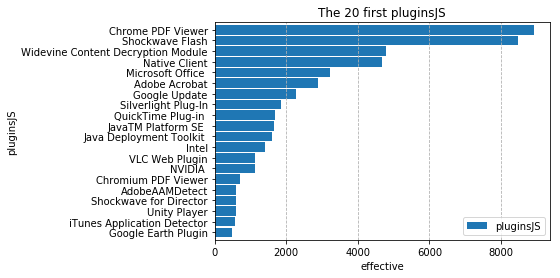

There are 106 unique terms for the attribute 'pluginsJS'

The most used terms are: 
Chrome PDF Viewer                     8912
Shockwave Flash                       8474
Widevine Content Decryption Module    4792
Native Client                         4679
Microsoft Office                      3228
Name: pluginsJS, dtype: int64

There are 460 pluginsJS


In [255]:
analysis_terms_splited(df_consistent, 'pluginsJS', split_plugins)

In [10]:
def analyze_grouped(df, attribute, group_by_attribute):
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df_consistent['id'] == user_id]
        os_user = df_user_id["os"].values[0]
        browser_user = df_user_id["browserFamily"].values[0]

        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                "os": os_user,
                "browserFamily": browser_user,
                attribute: value
            })
  
    df_stats = pd.DataFrame(tmp_stats)
    stats_grouped = df_stats[group_by_attribute].value_counts()
    grouped = df_stats.groupby([attribute])
    for name, group in grouped:
        norm = 0 
        count_per_group = group[group_by_attribute].value_counts()
        for key, number in stats_grouped.iteritems():
            try:
                norm += abs(number - count_per_group[key])
            except KeyError:
                norm += abs(number)

        if norm >= 0:
            print(name)
            print(count_per_group)

        print(norm)

In [38]:
analyze_grouped(df_consistent,'localJS', 'sessionJS')

KeyError: 'sessionJS'

In [11]:
def analyze_grouped_splited(df, attribute, group_by_attribute, split_function):
    tmp_dataset = []
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df['id'] == user_id]
        os_user = df_user_id["os"].values[0]
        browser_user = df_user_id["browserFamily"].values[0]

        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                "os": os_user,
                "browserFamily": browser_user
            })
            values_split = split_function(value)

            for value_tmp in values_split:
                tmp_dataset.append({
                    "id": user_id,
                    "os": os_user,
                    "browserFamily": browser_user,
                    attribute: value_tmp

                })

    df_tmp = pd.DataFrame(tmp_dataset)
    df_stats = pd.DataFrame(tmp_stats)
    
    
    stats_grouped = df_stats.groupby(group_by_attribute).size()
    #print(stats_grouped)
    #stats_grouped = df_stats[group_by_attribute].value_counts()
    grouped = df_tmp.groupby([attribute])
    for name, group in grouped:
        norm = 0 
        count_per_group = group.groupby(group_by_attribute).size()
        #count_per_group = group[group_by_attribute].value_counts()
        for key, number in stats_grouped.iteritems():
            try:
                norm += (number - count_per_group[key])**2
            except KeyError:
                norm += number**2

        if norm >= 0:
            print(name)
            print(count_per_group)

        print(norm)

def split_headers(headers):
    return headers.split(" ")

def split_languages_http(languages):
    try:
        return languages.split(";")
    except AttributeError:
        return str(languages)
    
def split_accept_http(accept):
    return accept.split(",")

def split_plugins(attribute):
    return re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(attribute))

def split_order_http(order):
    return order.split(" ")

def split_encoding_http(encoding):
    try:
        replacement=encoding.replace(","," ")
        junction=''.join(replacement)
        disjunction=junction.split()
        return disjunction 
    except:
        return [""]

In [23]:
analyze_grouped_splited(df_consistent, 'encodingHttp', 'browserFamily', split_encoding_http)


browserFamily
Firefox    3
dtype: int64
11703118
br
browserFamily
Chrome            1597
Chromium            43
Dragon               3
Epiphany             1
Firefox           1912
IE Mobile            1
Iceweasel            3
Iron                28
Konqueror            1
Opera                8
Other                5
QupZilla             1
Rekonq               1
SeaMonkey            1
Vivaldi             38
Yandex Browser       4
dtype: int64
876300
bzip2
browserFamily
Chrome    1
dtype: int64
11713896
compress
browserFamily
Chrome    1
dtype: int64
11713896
deflate
browserFamily
Chrome                         2274
Chromium                         72
Dragon                            9
Epiphany                          2
Firefox                        2553
IE Mobile                         1
Iceweasel                        32
Iron                             37
Konqueror                         1
Maxthon                           1
Opera                            15
Other           

In [165]:
analyze_grouped_splited(df_consistent, 'vendorWebGLJS', ['os', 'browserFamily'], split_plugins)

os             browserFamily              
Chrome OS      Chrome                          72
FreeBSD        Chrome                           1
               Firefox                          3
Linux          Chrome                         304
               Firefox                        177
               Iceweasel                       32
               Iron                             6
               Konqueror                        1
               Opera                            1
               QupZilla                         1
               Rekonq                           1
               Vivaldi                         14
Mac OS X       Chrome                         390
               Firefox                        191
               Iron                             1
               Opera                            2
               SeaMonkey                        1
               Vivaldi                          6
NetBSD         Firefox                          1
OpenBSD

KeyError: 'vendorWebGLJS'

## Inconsistent fingerprint detection

In [139]:
dict_null=[]
for attribute in attributes_to_analyze:
    nb_values_null = len(df_consistent[df_consistent[attribute].isnull()])
    dict_null.append({
        "attribute":attribute,
        "number of values null":nb_values_null
    })
df_dict_null = pd.DataFrame(dict_null)
df_dict_null

,attribute,number of values null
0,id,0
1,addressHttp,0
2,userAgentHttp,7
3,acceptHttp,0
4,connectionHttp,0
5,encodingHttp,2
6,languageHttp,15
7,orderHttp,0
8,pluginsJSHashed,0
9,platformJS,1


In [142]:
# Détection of inconsistent values
df_consistent[df_consistent['platformJS'].isnull()]

,counter,id,creationDate,endDate,addressHttp,userAgentHttp,acceptHttp,connectionHttp,encodingHttp,languageHttp,...,platformFlash,browserFamily,globalBrowserVersion,minorBrowserVersion,majorBrowserVersion,os,rendererWebGLJS,vendorWebGLJS,pluginsJS,consistent
38502,49117,bb2d1703-0c56-49cd-bf02-4af5d1bceb30,2016-06-30 12:00:00,None,5aff60bc3b6c8c04f3c5934e10a9cfff857751a2,Mozilla/5.0 (Windows NT 6.0) AppleWebKit/537.3...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate","en-GB,en;q=0.5",...,Windows 7,Chrome,450,0,45,Windows Vista,Not supported,Not supported,Plugin 0: Adobe Acrobat; Adobe PDF Plug-In For...,True


In [119]:
# Id of the fingerprint to take off it from consistent fingerprints
df_consistent[df_consistent['id'] == "d2356d2d-9796-4522-949e-616aa1521059"]

,counter,id,creationDate,endDate,addressHttp,userAgentHttp,acceptHttp,connectionHttp,encodingHttp,languageHttp,...,platformFlash,browserFamily,globalBrowserVersion,minorBrowserVersion,majorBrowserVersion,os,rendererWebGLJS,vendorWebGLJS,pluginsJS,consistent
71595,93843,d2356d2d-9796-4522-949e-616aa1521059,2016-12-04 01:00:00,None,8f60d3ad84d108cabb80a4e40a488878396c0448,NaN,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, br","en-US,en;q=0.5",...,Flash not detected,Other,zzzzzz,None,None,Other,Not supported,Not supported,NaN,True


In [109]:
df_consistent['browserFamily'].value_counts()

Chrome                         28157
Firefox                        19183
Chromium                         425
Iron                             353
Vivaldi                          220
Iceweasel                        141
Opera                             71
Dragon                            37
Yandex Browser                    21
Other                             11
IE Mobile                          3
Epiphany                           2
Pale Moon (Firefox Variant)        2
Maxthon                            1
Rekonq                             1
QupZilla                           1
SeaMonkey                          1
Konqueror                          1
Name: browserFamily, dtype: int64

In [165]:
df_consistent[df_consistent['encodingHttp'] == "gzip, deflate, , br"]["id"]

82110    b6c38cfd-7fc0-4591-b908-bcd7769ab2b5
Name: id, dtype: object

## Temporal analysis of consistent fingerprints

In [5]:
#id with more 2 fingerprints
number_fingerprints_by_id=df_consistent['id'].value_counts()
df_number_fingerprints_by_id=pd.DataFrame(number_fingerprints_by_id)
user_more_2_fingerprints=[]
for user_id, number in df_number_fingerprints_by_id.iteritems():
    for i in range(0, len(number)):
        if number[i] != 1:
            user_more_2_fingerprints.append({
                "valeur":number[i],
                "index":number.index[i]
            })
            
df_user_more_2_fingerprints=pd.DataFrame(user_more_2_fingerprints)

### Number of plugins in time

In [8]:
print("The following analysis is done from {} to {}".format(min(df_consistent['creationDate']),max(df_consistent['creationDate'])))

The following analysis is done from 2015-07-27 11:00:00 to 2017-03-13 01:00:00


In [141]:
evolution=[]

# for each user, storage of the date
for user_id in df_user_more_2_fingerprints['index']:
    date=df_consistent[df_consistent['id']==user_id]['creationDate']  
    df_date = pd.DataFrame(date)
    df_date = df_date['creationDate'].apply(lambda x: x.strftime('%B-%Y'))
    year_month=[]
    for key, line in df_date.iteritems():
        year_month.append({
            "cle": key,
            "Date":line
        })

    df_year_month = pd.DataFrame(year_month)
    
    plugins = df_consistent[df_consistent['id']==user_id]['pluginsJS']
    df_plugins = pd.DataFrame(plugins)
    nb_plugins = df_plugins['pluginsJS']
    liste=[]
    for key, line in nb_plugins.iteritems():
        liste.append({
            "cle": key,
            "number of plugins":len(str(line).split(":"))-1
        })
          
    df_liste = pd.DataFrame(liste)
    annee_mois_nb_plugins = df_year_month.join(df_liste['number of plugins'])
    
    # get the last: -1 for the lest line and 2 for the column 'number of plugins'
    nb_fin=annee_mois_nb_plugins.iloc[-1,2]
    nb_debut=annee_mois_nb_plugins.iloc[0,2]
    nb_final=nb_fin-nb_debut

    list_final = []
    list_final.append(nb_final)
    df_list_final = pd.DataFrame(list_final)
    evolution.append(nb_final)
    
count_inf=0
count_sup=0
count_zero=0
for i in range(0,len(evolution)):
    if evolution[i]<0:
        count_inf=count_inf+1
    elif evolution[i]>0:
        count_sup=count_sup+1
    else:
        count_zero=count_zero+1
print("The number of plugins decreases for {:d} id".format(count_inf))
print("The number of plugins increases for {:d} id".format(count_sup))
print("The number of plugins stagnates for {:d} id".format(count_zero))

The number of plugins decreases for 677 id
The number of plugins increases for 298 id
The number of plugins stagnates for 1545 id
Conclusion: over time, the number of plugins tends to stagnate


/home/spirals/PycharmProjects/stage/myvenv/lib/python3.6/site-packages/ipykernel_launcher.py:51: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)


Text(0,0.5,'Number of plugins on average')

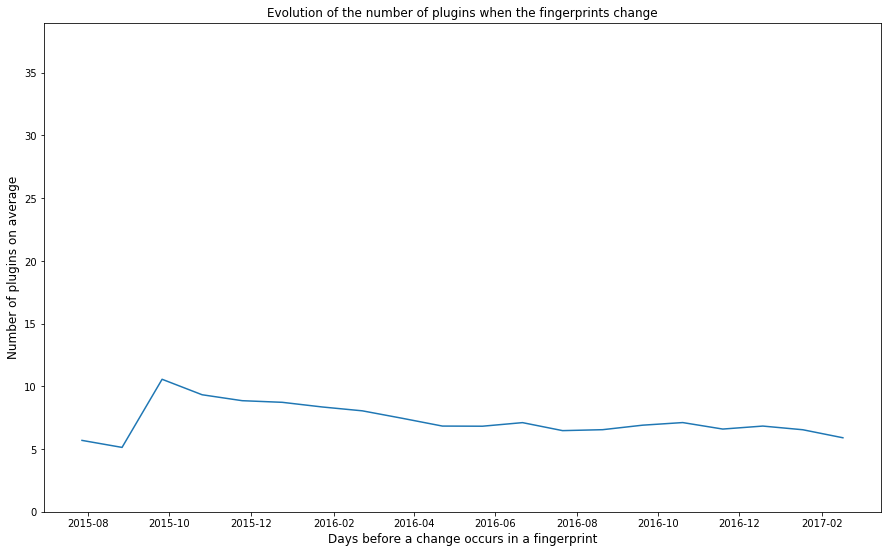

In [147]:
plugins_changes=[]

for user_id in df_user_more_2_fingerprints['index']:
    
    # sort the dataframe by date of creation
    df_filtered_id = df_consistent[df_consistent['id']==user_id].sort_values('creationDate')

    # delete columns not to be analyzed (0 for line and 1 for column)
    df_filtered_date = df_filtered_id.drop('counter', 1).drop('endDate', 1).drop('consistent', 1).drop('creationDate', 1)

    # initialization of variable 
    first_line = df_filtered_date.iloc[0]
    list_first_line = list(first_line)
    
    # storage of the firt values of attributes "date" and "plug"
    plugins_changes.append({
        "date": df_filtered_id.iloc[0]['creationDate'],
        "plug":len(str(df_filtered_date["pluginsJS"].iloc[0]).split(":"))-1
    })

    # for each line of group of fingerprints of the user
    for line in range(1, len(df_filtered_date)):
        line_entire=df_filtered_date.iloc[line]
        list_line_entire = list(line_entire)
        
        # if line next is different to previous line then storage of date and number of plugins in a dict
        if list_line_entire != list_first_line:
            date_line = df_filtered_id.iloc[line]['creationDate']
            number_of_plugins = len(str(df_filtered_date["pluginsJS"].iloc[line]).split(":"))-1
            plugins_changes.append({
                "date": date_line,
                "plug":number_of_plugins
            })
            first_line = line_entire
            
        # else the first line becomes the next
        else:
            first_line = line_entire
            

# sort of dataframe by date
df_plugins_changes = pd.DataFrame(plugins_changes)
sorting_df_plugins_changes=df_plugins_changes.sort_values("date")

# enlarge the chart
fig = plt.figure(figsize=(15,9))

graph_plugins_changes = fig.add_subplot(1, 1, 1)

# groups the number of plugins by date and makes an average
average_plugins_by_xday=sorting_df_plugins_changes.set_index('date').groupby(pd.TimeGrouper('30D')).mean()

graph_plugins_changes.plot(average_plugins_by_xday)

# interval of the y-axis 
graph_plugins_changes.set_ylim(0,max(sorting_df_plugins_changes.plug))

graph_plugins_changes.set_title("Evolution of the number of plugins when the fingerprints change")
graph_plugins_changes.set_xlabel("Days before a change occurs in a fingerprint", size = 12)
graph_plugins_changes.set_ylabel("Number of plugins on average", size = 12)


### Number of language in time

In [163]:
a=df_consistent['languageHttp'].iloc[1].split(",")
a

['en-US', 'en;q=0.8', 'fr;q=0.6']

### Frequency of attributes changes

In [164]:
#frequency of changes of each attribute in time (days)
List_frequency_attributes=[]
attribute_to_times = dict()

#take only users with more 2 fingerprints to see the evolution in fingerprints for each user
for user_id in df_user_more_2_fingerprints['index']:
    df_filtered_id = df_consistent[df_consistent['id']==user_id].sort_values('creationDate')

    #for each attribute, we store the date of creation and the first value of the first fingerprint of user
    for attribute in attributes_to_analyze:
        first_value_date = df_filtered_id.iloc[0]['creationDate']
        first_value = df_filtered_id.iloc[0][attribute]
        
        #if there are no changes
        if attribute not in attribute_to_times:
            attribute_to_times[attribute] = []
        
        last_change = False
        
        #count the number of days between each changes in the attribute then store it in a dict
        for index, row in df_filtered_id.iterrows():
            if row[attribute]!= first_value:
#                 print(row[attribute])
#                 print(first_value)
#                 print()
                date_next=row['creationDate']
                attribute_to_times[attribute].append((date_next-first_value_date).days)
                first_value_date=row['creationDate']
                first_value=row[attribute]
            
                #if there is a change in the n-1 value then we say that there is a last change
                if index == len(df_filtered_id) -1:
                    last_change = True
            

        #Otherwise, we add to the list the NaN value    
        if not last_change:
            attribute_to_times[attribute].append(np.nan)
          
            
            
dict_stat=[]
for attribute in attribute_to_times:
    #try:
        # sort in descending order
    arr = np.sort(attribute_to_times[attribute])[::-1]

    #creation of quantiles
    Q95 = arr[int(0.95*len(arr))]
    Q90 = arr[int(0.90*len(arr))]
    median = arr[int(0.50*len(arr))]
    dict_stat.append({
        "attribute":attribute,
        "Q90":Q90,
        "median":median,
        "Q95":Q95
    })
    #except IndexError:
#        pass

#create a dataframe for the visualization
df_stat = pd.DataFrame(dict_stat)

#put in index the name of attributes
df_stat = df_stat.set_index("attribute")

#replace NaN by 'Never'
for column in df_stat:
    df_stat[column].replace(to_replace=[NaN], value='Never', inplace=True) 

df_stat_order = df_stat[['median','Q90','Q95']]
df_stat_order

,median,Q90,Q95
attribute,,,
id,Never,Never,Never
addressHttp,2,0,0
userAgentHttp,23,0,0
acceptHttp,Never,Never,Never
connectionHttp,Never,Never,Never
encodingHttp,Never,11,0
languageHttp,Never,5,0
orderHttp,Never,0,0
pluginsJSHashed,28,0,0


### Does everyone change so often ?

In [22]:
list_all=[]
list_freq=[]
for user_id in df_user_more_2_fingerprints['index']:
    df_filtered_id = df_consistent[df_consistent['id']==user_id].sort_values('creationDate')

    # delete columns not to be analyzed (0 for line ans 1 for column)
#     df_filtered_counter = df_filtered_id.drop('counter', 1)
#     df_filtered_endDate = df_filtered_counter.drop('endDate', 1)
#     df_filtered_consistent = df_filtered_endDate.drop('consistent', 1)
#     df_filtered_date = df_filtered_consistent.drop('creationDate', 1)
    
    df_filtered_date = df_filtered_id.drop('counter', 1).drop('endDate', 1).drop('consistent', 1).drop('creationDate', 1)

    liste_time = []

    first_line = df_filtered_date.iloc[0]
    list_first_line = list(first_line)

    first_value_date = df_filtered_id.iloc[0]['creationDate']
    last_value_date = df_filtered_id.iloc[-1]['creationDate']

    # for each line of group of fingerprints of the user
    for line in range(1, len(df_filtered_date)):
        line_entire=df_filtered_date.iloc[line]
        list_line_entire = list(line_entire)
        
        # if line next is defferent to previous line then storage of number of days between the two lines
        if list_line_entire != list_first_line:
            date_line = df_filtered_id.iloc[line]['creationDate']
            liste_time.append((date_line-first_value_date).days)
            first_value_date = df_filtered_id.iloc[line]['creationDate']
            first_line = line_entire
        # else the first line becomes the next
        else:
            first_line = line_entire
    
    # storage of all values in a single list for cumulative distribution for all fingerprints
#     list_all.append(np.nanmean(liste_time))
    # average of each list of values for each user
#     mean_liste=np.nanmean(liste_time)
    list_freq.append({
        'user':user_id,
        'mean':np.nanmean(liste_time)
    })

# for the visualization : creation a dataframe
df_list_freq=pd.DataFrame(list_freq)
df_list_freq

/home/spirals/PycharmProjects/stage/myvenv/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice


,mean,user
0,0.101572,c3af36ba-81f4-4652-9523-44f2217dc0f0
1,0.290965,2bef0281-b2d9-41ac-967c-45835e5ba8c0
2,0.294393,efca79c2-0b12-4ce7-a28f-68ad9193990d
3,0.000000,77aae6f6-0bbd-4138-baa4-142c1e4dddcd
4,0.801402,f61809d2-a428-4a2c-81e4-461ea9908687
5,0.904878,d4be492d-c9ee-46a0-b1ab-076386b61b85
6,0.780488,68942969-0475-4a26-931b-d1d8043a659c
7,0.801090,31fa27b8-6c4d-47b2-8566-b4af4d9ca9e8
8,1.395498,c17f5405-360e-43d7-9b50-bccf6faf2207
9,0.842697,b8f4eb79-baaf-442b-ada2-5bcd5cf89df4


In [8]:
# graph
# max_abs is the value for the maximum of the abscissa axe and probability = [0.0:1.0]

def CDF_evolution(max_abs, probability):  
    
    # sort 
    x_fig_average = np.sort(df_list_freq['mean'])
    x_fig_all = np.sort(list_all)

    # length
    N_fig_average = len(x_fig_average)
    N_fig_all = len(x_fig_all)

    #creation of the y-axis for a cumulative distribution function
    y_fig_average = np.array(range(N_fig_average))/float(N_fig_average)
    y_fig_all = np.array(range(N_fig_all))/float(N_fig_all)

    # dimension of the figure
    fig = plt.figure(figsize=(15,9))

    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x_fig_all, y_fig_all, label = 'Over all fingerprints')
    ax.plot(x_fig_average, y_fig_average, label = 'Average per user')
    
    # horizontal line for the percentile
    ax.plot([0.0, 50],[probability,probability], 'g--', lw=2)

    # legend in better place
    ax.legend(loc='best', prop={'size': 12})

    # interval of the abscissa axis and y-axis 
    ax.set_xlim(-0.05, max_abs)
    ax.set_ylim(0,1)
    
    ax.set_title("Cumulative distribution function of the elapsed time before a fingerprint evolution \nover all fingerprints and averaged per user\n")
    ax.set_xlabel("Days before a change occurs in a fingerprint", size = 12)
    ax.set_ylabel("P(X)", size = 12)
    
    # graduation of abscissa axis with a one step
    ax.xaxis.set_major_locator(MultipleLocator(1))


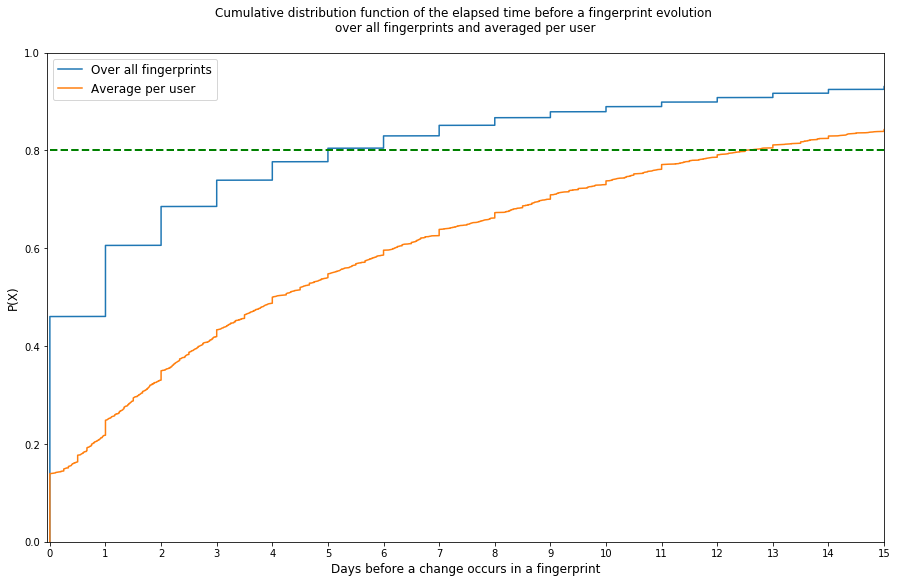

In [181]:
CDF_evolution(15,0.8)

### Attributes that change at the same time

In [24]:
df_consistent['creationDate'].iloc[-1] - df_consistent['creationDate'].iloc[0]

Timedelta('594 days 14:00:00')

In [16]:
# initialization of a dictionnary
attribute_changes = dict()

#take only users with more 2 fingerprints to see the evolution in fingerprints for each user
for user_id in df_user_more_2_fingerprints['index']:
    df_filtered_id = df_consistent[df_consistent['id']==user_id].sort_values('creationDate')

    #for each attribute, we store the date of creation and the first value of the first fingerprint of user
    for attribute in attributes_to_analyze:
        #first_value_date = df_filtered_id.iloc[0]['creationDate']
        first_value = df_filtered_id.iloc[0][attribute]
        
        #if there are no changes
        if attribute not in attribute_changes:
            attribute_changes[attribute] = []

        
        #count the number of days between each changes in the attribute then store it in a dict
        for index, row in df_filtered_id.iterrows():
            if row[attribute]!= first_value:
                #date_next=row['creationDate']
                #attribute_changes[attribute].append((date_next-first_value_date).days)
                attribute_changes[attribute].append(1)
                #first_value_date=row['creationDate']
                first_value=row[attribute]

            else:
                #attribute_changes[attribute].append(650)
                attribute_changes[attribute].append(0)

df_attribute_changes = pd.DataFrame(attribute_changes)
df_attribute_changes

,acceptHttp,addressHttp,browserFamily,canvasJSHashed,connectionHttp,cookiesJS,dntJS,encodingHttp,fontsFlashHashed,globalBrowserVersion,...,platformJS,pluginsJS,pluginsJSHashed,rendererWebGLJS,resolutionFlash,resolutionJS,sessionJS,timezoneJS,userAgentHttp,vendorWebGLJS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
# The deletion of attributes is done in sup_attributes, not in attributes_to_analyze
sup_attributes = [attribute for attribute in df.columns.tolist() if attribute not in ATTRIBUTES_TO_EXCLUDE]

# creation an empty dataframe
df_correlation=pd.DataFrame()

for attribute_to_compare in attributes_to_analyze:
    correlation=[]
    remaining_attributes = sup_attributes
    
    for attribute in remaining_attributes: 
        
        # Initialization of variables
        first_value_attribute = df_attribute_changes.iloc[0][attribute]
        first_value_attribute_to_compare = df_attribute_changes.iloc[0][attribute_to_compare]

        # calculation of the correlation between the variable to compare and each remaining variable 
        correlation.append(df_attribute_changes[attribute].corr(df_attribute_changes[attribute_to_compare], method='pearson'))
    
    # Deleting of attribute that we have just compared in the remaining list
    remaining_attributes = remaining_attributes.remove(attribute_to_compare)
    
    # adding white in columns to merge all columns together
    while len(correlation) != len(attributes_to_analyze):
        a=" "
        correlation = [a]+correlation
    
    # adding the created column in dataframe
    df_correlation[attribute_to_compare] = correlation
 
 # adding a column to index the attributes
df_correlation["attribute"]=attributes_to_analyze
df_correlation= df_correlation.set_index("attribute")

# delete columns and rows with missing data for an attribute because it does not change over time 
# thresh is an optional that requires a given number of non-missing values
df_correlation = df_correlation.dropna(axis=1,thresh=26)
df_correlation = df_correlation.dropna(axis=0,thresh=24)
df_correlation = df_correlation.drop(['id'])
df_correlation

,addressHttp,userAgentHttp,acceptHttp,encodingHttp,languageHttp,orderHttp,pluginsJSHashed,platformJS,cookiesJS,dntJS,...,fontsFlashHashed,resolutionFlash,languageFlash,platformFlash,globalBrowserVersion,minorBrowserVersion,majorBrowserVersion,rendererWebGLJS,vendorWebGLJS,pluginsJS
attribute,,,,,,,,,,,,,,,,,,,,,
addressHttp,1,,,,,,,,,,...,,,,,,,,,,
userAgentHttp,-0.0854949,1,,,,,,,,,...,,,,,,,,,,
acceptHttp,0.0163983,0.0370858,1,,,,,,,,...,,,,,,,,,,
encodingHttp,-0.0128005,0.10387,0.142806,1,,,,,,,...,,,,,,,,,,
languageHttp,-0.0264431,0.0582013,0.169873,0.0469862,1,,,,,,...,,,,,,,,,,
orderHttp,-0.034465,0.100459,-0.00482548,0.099236,0.0725599,1,,,,,...,,,,,,,,,,
pluginsJSHashed,-0.0932849,0.162132,0.0393349,0.0253334,0.00149926,0.030337,1,,,,...,,,,,,,,,,
platformJS,-0.00634697,0.0994373,0.101664,0.0582547,0.0458436,0.0520749,0.0942608,1,,,...,,,,,,,,,,
cookiesJS,-0.0153838,-0.00959464,0.0246977,-0.00440124,0.0117221,0.0348597,-0.00854157,0.0108735,1,,...,,,,,,,,,,


In [18]:
# part of the missing table
df_correlation[df.columns[15 :21]]

,timezoneJS,resolutionJS,localJS,sessionJS,canvasJSHashed,fontsFlashHashed
attribute,,,,,,
addressHttp,,,,,,
userAgentHttp,,,,,,
acceptHttp,,,,,,
encodingHttp,,,,,,
languageHttp,,,,,,
orderHttp,,,,,,
pluginsJSHashed,,,,,,
platformJS,,,,,,
cookiesJS,,,,,,


In [76]:
# save of the table for a complete visualization
df_correlation.to_csv('/home/spirals/Documents/attributes_change_corre.csv', index=True)

In [120]:
def polyfit(x, y, degree):
    results = {}

    coeffs = numpy.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = numpy.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = numpy.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = numpy.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = numpy.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot

    return results

In [121]:
polyfit(df_attribute_changes['rendererWebGLJS'], df_attribute_changes['vendorWebGLJS'], 1)

{'polynomial': [0.5740626335711246, 276.7721254036852],
 'determination': 0.5672386868723794}

In [18]:
res.pca = PCA(n_components=3)
pca.fit(df_attribute_changes)
pca.explained_variance_ratio_
pca.components_

array([[ 4.29738409e-04, -1.52235065e-01,  1.44054013e-19,
         9.34657939e-03,  1.20607075e-22,  8.03325473e-04,
         3.46657848e-03,  5.94031076e-03, -4.96352073e-01,
         2.12549909e-02, -1.39179787e-25, -4.97692432e-01,
         6.32712912e-03,  3.93582005e-03,  2.08964383e-02,
         6.18530493e-04,  5.46918771e-03, -0.00000000e+00,
        -4.99560278e-01,  5.70621097e-04, -1.33833089e-02,
        -4.00196606e-02, -5.01521038e-04, -4.68581208e-01,
         9.24517213e-02,  2.60432756e-03,  1.86273239e-02,
         4.28985950e-02,  3.84760303e-04],
       [-1.08883926e-03,  2.64482978e-01, -3.78616929e-18,
        -3.51058565e-02,  1.56150900e-20, -1.07595542e-03,
        -1.04961613e-02, -1.75869240e-02, -1.75989309e-01,
        -2.09852664e-01,  3.78543472e-26, -6.89527902e-02,
        -1.45133761e-02, -4.05372390e-03, -2.08688175e-01,
        -1.76814448e-03, -3.80777280e-02, -0.00000000e+00,
        -7.85701451e-02, -6.72266333e-03, -3.45135008e-01,
        -3.22

In [63]:
S = np.diag(1/df_attribute_changes.iloc[:,0:30].std())
mu = np.matrix(df_attribute_changes.iloc[:,0:30].mean())
U = np.matrix([np.ones(df_attribute_changes.iloc[:,0:30].shape[0])])
X = pd.DataFrame((df_attribute_changes.iloc[:,0:30] - U.T.dot(mu)).dot(S).values,columns = df_attribute_changes.columns[0:30])

In [31]:
Var_X = X.cov()

# delete 
Var_X = Var_X.dropna(axis=1,thresh=1)
Var_X = Var_X.dropna(axis=0,thresh=1)
Var_X

,acceptHttp,addressHttp,canvasJSHashed,cookiesJS,dntJS,encodingHttp,fontsFlashHashed,globalBrowserVersion,languageFlash,languageHttp,...,platformJS,pluginsJS,pluginsJSHashed,rendererWebGLJS,resolutionFlash,resolutionJS,sessionJS,timezoneJS,userAgentHttp,vendorWebGLJS
acceptHttp,1.000000,0.016744,-0.005354,0.024996,-0.002389,0.154290,-0.017038,-0.003139,-0.011377,0.176483,...,0.105488,0.041520,0.041085,-0.003137,-0.017887,-0.015252,-0.001456,-0.005153,0.038663,-0.002393
addressHttp,0.016744,1.000000,-0.024976,-0.015408,-0.026298,-0.013867,0.016959,-0.064091,0.156477,-0.027215,...,-0.005878,-0.086789,-0.099548,0.001426,0.149891,0.011564,-0.017940,0.076592,-0.091171,-0.031645
canvasJSHashed,-0.005354,-0.024976,1.000000,-0.004044,0.015902,0.034569,-0.035353,0.218668,-0.017576,0.043275,...,0.031655,0.077216,0.073305,0.190286,-0.011295,0.029779,0.001063,0.029657,0.141216,0.127424
cookiesJS,0.024996,-0.015408,-0.004044,1.000000,0.036364,-0.004367,-0.018110,-0.004969,-0.006870,0.012502,...,0.011511,0.019418,-0.008501,-0.005124,-0.020854,-0.022725,0.385252,-0.005595,-0.009780,-0.003909
dntJS,-0.002389,-0.026298,0.015902,0.036364,1.000000,0.015323,-0.033323,0.017861,-0.003946,0.076492,...,0.042493,0.036373,0.010664,-0.003323,-0.040390,-0.058001,0.075019,0.003517,0.005354,0.003625
encodingHttp,0.154290,-0.013867,0.034569,-0.004367,0.015323,1.000000,-0.040179,0.139213,-0.019384,0.053690,...,0.062393,0.021186,0.020836,0.010514,-0.054388,-0.063029,0.009922,-0.011136,0.095716,0.017971
fontsFlashHashed,-0.017038,0.016959,-0.035353,-0.018110,-0.033323,-0.040179,1.000000,-0.050369,0.663435,-0.049744,...,-0.013126,-0.038481,0.019469,-0.002151,0.333372,-0.317446,-0.034513,-0.090132,-0.078943,-0.004013
globalBrowserVersion,-0.003139,-0.064091,0.218668,-0.004969,0.017861,0.139213,-0.050369,1.000000,0.003806,0.091082,...,0.083388,0.197525,0.206345,0.073113,-0.086921,-0.133346,0.018744,-0.018141,0.681598,0.089075
languageFlash,-0.011377,0.156477,-0.017576,-0.006870,-0.003946,-0.019384,0.663435,0.003806,1.000000,-0.019191,...,0.000231,0.085580,0.133120,0.011229,0.628808,-0.202192,-0.016467,-0.034383,-0.014050,0.003350
languageHttp,0.176483,-0.027215,0.043275,0.012502,0.076492,0.053690,-0.049744,0.091082,-0.019191,1.000000,...,0.045488,0.028883,0.001203,0.084451,-0.055577,-0.065465,0.032936,-0.005356,0.059235,0.119694


In [65]:
val_propres,vec_propres = np.linalg.eig(Var_X)
ordre = val_propres.argsort()[::-1]
val_propres = val_propres[ordre]
vec_propres = vec_propres[:,ordre]
print(val_propres)
vec_propres

[3.14578793e+00 3.04282258e+00 2.08774707e+00 1.82656272e+00
 1.67778965e+00 1.49066018e+00 1.28983499e+00 1.24344365e+00
 1.08669502e+00 9.98201403e-01 9.43571803e-01 9.30168458e-01
 8.95575030e-01 8.31104753e-01 7.74883881e-01 7.38580262e-01
 4.96156668e-01 4.33228963e-01 3.13263972e-01 2.40562907e-01
 2.03046980e-01 1.85652181e-01 9.89707468e-02 2.43553276e-02
 1.33288450e-03]


array([[ 4.08315145e-02,  7.85432636e-03,  1.41547167e-02,
         1.68575300e-02, -5.13841982e-02,  1.18788252e-01,
         9.80836313e-02, -6.72416893e-01,  1.01566225e-02,
         3.25158246e-02, -1.34548944e-01,  7.15989805e-03,
         6.97932256e-02,  4.40695000e-02, -4.64588370e-01,
        -5.19071969e-01, -2.07134688e-02, -6.33807333e-02,
        -5.79373965e-02, -2.15045527e-03, -2.18844026e-03,
         5.96664060e-03,  3.90724668e-03,  9.70284127e-04,
        -4.20637966e-04],
       [-1.25589875e-01,  5.20377778e-02, -1.63066169e-02,
        -6.14596475e-02,  9.57753803e-02, -5.61151920e-04,
         2.98020688e-02, -9.85998393e-02,  6.44915783e-01,
        -7.32143410e-02, -1.03402328e-01,  1.78457608e-03,
        -4.44454195e-01, -5.53122611e-01,  1.13913092e-02,
         2.34480632e-02,  1.62455412e-03, -6.17331078e-02,
         1.23201380e-01,  4.08035718e-02, -1.60255535e-02,
        -1.97996066e-02, -1.51881388e-02,  4.50198989e-03,
         3.87794633e-04],
    

In [45]:
row = ["Comp." + str(i+1) for i in range(25)]
col = ["Std deviation","Prop.of Variance(%)","Cumulative Prop.(%)"]
tot = sum(val_propres)
res_1 = pd.DataFrame([[i**0.5,np.round(i*100 /tot,2),np.round(j*100/tot,2)]
                      for i,j in zip(val_propres,np.cumsum(val_propres))],
                        columns= col,index = row)
res_2 = pd.DataFrame(vec_propres,columns = row,
                                 index = Var_X.columns[0:26])


res_1

,Std deviation,Prop.of Variance(%),Cumulative Prop.(%)
Comp.1,1.773637,12.58,12.58
Comp.2,1.744369,12.17,24.75
Comp.3,1.444904,8.35,33.11
Comp.4,1.351504,7.31,40.41
Comp.5,1.295295,6.71,47.12
Comp.6,1.220926,5.96,53.09
Comp.7,1.135709,5.16,58.24
Comp.8,1.115098,4.97,63.22
Comp.9,1.042447,4.35,67.57
Comp.10,0.999100,3.99,71.56


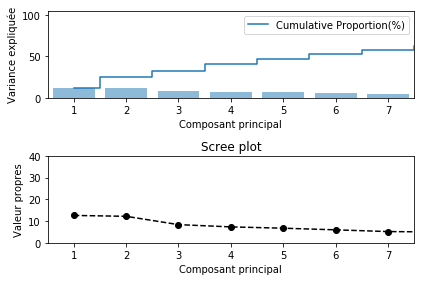

In [53]:
plt.clf()
plt.subplot(211)
plt.axis([0.5,7.5,0,105])
plt.bar(range(1,26), res_1.iloc[:,1], alpha=0.5)
plt.step(range(1,26),res_1.iloc[:,2], where='mid',
             label="Cumulative Proportion(%)")
plt.ylabel("Variance expliquée")
plt.xlabel("Composant principal")
plt.legend(loc='best')
plt.subplot(212)
plt.axis([0.5,7.5,0,40])
plt.plot(range(1,26),res_1.iloc[:,1], linestyle='--',
              marker='o', color='black')
plt.ylabel("Valeur propres")
plt.xlabel("Composant principal")
plt.title("Scree plot")
plt.tight_layout()
plt.show()

In [80]:
df_user_more_2_fingerprints

,index,valeur
0,c3af36ba-81f4-4652-9523-44f2217dc0f0,828
1,2bef0281-b2d9-41ac-967c-45835e5ba8c0,658
2,efca79c2-0b12-4ce7-a28f-68ad9193990d,643
3,77aae6f6-0bbd-4138-baa4-142c1e4dddcd,534
4,f61809d2-a428-4a2c-81e4-461ea9908687,429
5,d4be492d-c9ee-46a0-b1ab-076386b61b85,411
6,68942969-0475-4a26-931b-d1d8043a659c,370
7,31fa27b8-6c4d-47b2-8566-b4af4d9ca9e8,368
8,c17f5405-360e-43d7-9b50-bccf6faf2207,312
9,b8f4eb79-baaf-442b-ada2-5bcd5cf89df4,268
